
# Salaire EQTP — Pipeline complet (Notebook)

Ce notebook exécute **Nettoyage → Exploration → Feature engineering → Entraînement → Évaluation → Interprétation → Export du modèle**.

**Fichiers attendus :**



In [1]:

# 1) Imports & configuration
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer

import joblib

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

DATA_PATH = r"dataset/DS_BTS_SAL_EQTP_SEX_PCS_2023_data.csv"

META_PATH = r"dataset/DS_BTS_SAL_EQTP_SEX_PCS_2023_metadata.csv"

In [2]:

# 2) Chargement des données
data = pd.read_csv(DATA_PATH, sep=";")
meta = pd.read_csv(META_PATH, sep=";")

print("Shape:", data.shape)
display(data.head())
display(meta.head())


Shape: (370710, 9)


,GEO,GEO_OBJECT,FREQ,SEX,PCS_ESE,DERA_MEASURE,CONF_STATUS,TIME_PERIOD,OBS_VALUE
0,26362,BV2022,A,F,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2157.284701
1,26324,BV2022,A,_T,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,3112.937532
2,26307,BV2022,A,_T,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2013.097449
3,26362,BV2022,A,_T,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2483.037253
4,27170,BV2022,A,F,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2107.221064


,COD_VAR,LIB_VAR,COD_MOD,LIB_MOD
0,CONF_STATUS,Statut de confidentialité,F,Diffusable
1,CONF_STATUS,Statut de confidentialité,C,Confidentiel (secret statistique)
2,DERA_MEASURE,Mesure des salaires,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,Salaire net EQTP mensuel moyen
3,FREQ,Fréquence,A,Annuel
4,PCS_ESE,Profession et catégorie socio-professionnelle ...,1T3,Cadres y compris chefs d’entreprises


In [3]:

# 3) Nettoyage des données
if "DERA_MEASURE" in data.columns:
    data = data[data["DERA_MEASURE"]=="SALAIRE_NET_EQTP_MENSUEL_MOYENNE"]
if "CONF_STATUS" in data.columns:
    data = data[data["CONF_STATUS"]=="F"]
if "FREQ" in data.columns:
    data = data[data["FREQ"]=="A"]

data = data[data["TIME_PERIOD"].isin([2022, 2023])]
data = data[(data["OBS_VALUE"].notna()) & (data["OBS_VALUE"]>0) & (data["OBS_VALUE"]<15000)]
key_cols = [c for c in ["GEO","SEX","PCS_ESE","TIME_PERIOD"] if c in data.columns]
data = data.drop_duplicates(subset=key_cols)

print("Après nettoyage:", data.shape)
data.head()


Après nettoyage: (286890, 9)


,GEO,GEO_OBJECT,FREQ,SEX,PCS_ESE,DERA_MEASURE,CONF_STATUS,TIME_PERIOD,OBS_VALUE
0,26362,BV2022,A,F,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2157.284701
1,26324,BV2022,A,_T,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,3112.937532
2,26307,BV2022,A,_T,6,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2013.097449
3,26362,BV2022,A,_T,_T,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2023,2483.037253
4,27170,BV2022,A,F,4,SALAIRE_NET_EQTP_MENSUEL_MOYENNE,F,2022,2107.221064


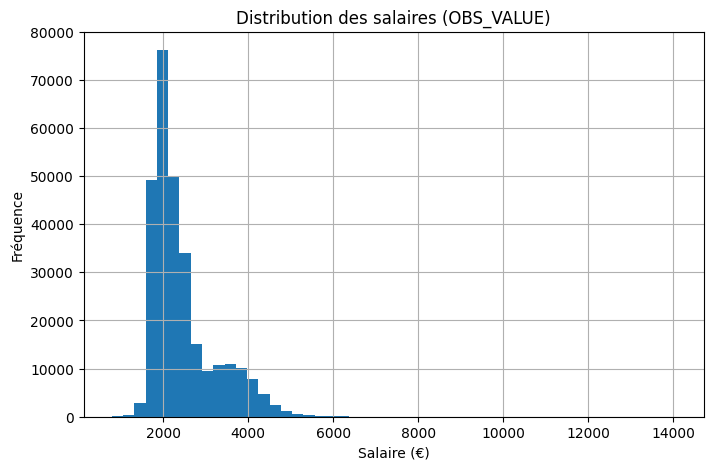

C:\Users\User\AppData\Local\Temp\ipykernel_21376\3717261383.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data["OBS_VALUE"].dropna(), labels=["OBS_VALUE"], vert=True)


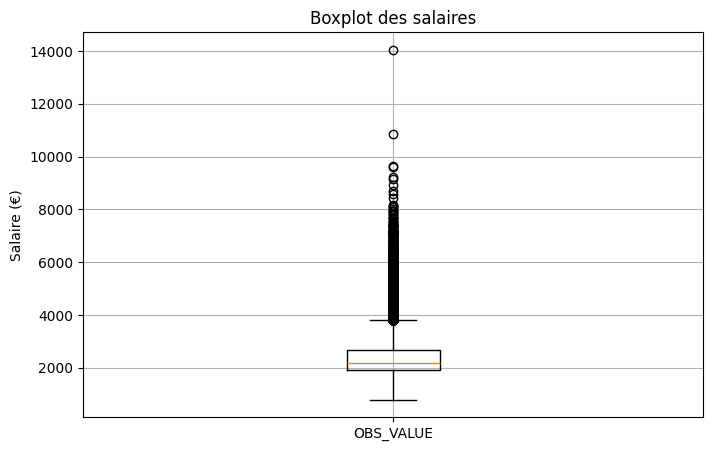

C:\Users\User\AppData\Local\Temp\ipykernel_21376\3717261383.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(by_sex, labels=labels, vert=True)


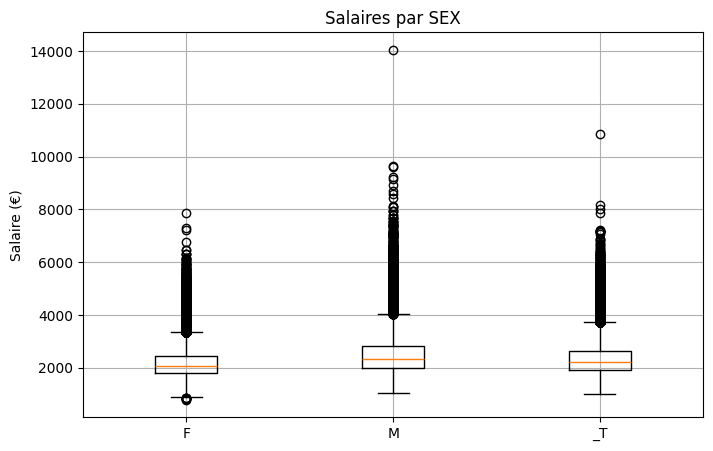

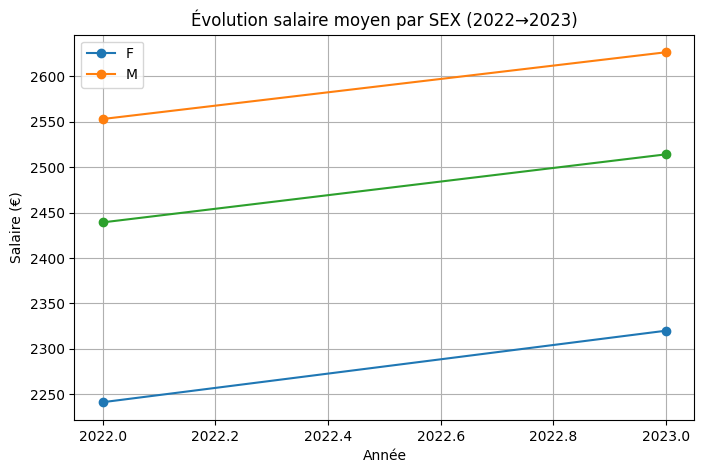

In [4]:

# 4) EDA — matplotlib uniquement

# Histogramme
plt.figure()
plt.hist(data["OBS_VALUE"].dropna(), bins=50)
plt.title("Distribution des salaires (OBS_VALUE)")
plt.xlabel("Salaire (€)")
plt.ylabel("Fréquence")
plt.show()

# Boxplot global
plt.figure()
plt.boxplot(data["OBS_VALUE"].dropna(), labels=["OBS_VALUE"], vert=True)
plt.title("Boxplot des salaires")
plt.ylabel("Salaire (€)")
plt.show()

# Boxplot par sexe
if "SEX" in data.columns:
    by_sex = [grp.dropna().values for _, grp in data.groupby("SEX")["OBS_VALUE"]]
    labels = [str(k) for k, _ in data.groupby("SEX")]
    plt.figure()
    plt.boxplot(by_sex, labels=labels, vert=True)
    plt.title("Salaires par SEX")
    plt.ylabel("Salaire (€)")
    plt.show()

# Courbe temporelle par sexe
if set(["TIME_PERIOD","SEX"]).issubset(data.columns):
    means_ts = data.groupby(["TIME_PERIOD","SEX"])["OBS_VALUE"].mean().reset_index()
    pivot = means_ts.pivot(index="TIME_PERIOD", columns="SEX", values="OBS_VALUE")
    plt.figure()
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker="o", label=str(col))
    plt.title("Évolution salaire moyen par SEX (2022→2023)")
    plt.xlabel("Année"); plt.ylabel("Salaire (€)"); plt.legend()
    plt.show()


In [5]:

# 5) Features
df = data.copy()
df["YEAR"] = df["TIME_PERIOD"] - 2022

y = df["OBS_VALUE"].astype(float)
X = df[["YEAR","SEX","PCS_ESE","GEO"]].copy()

num_cols = ["YEAR"]
cat_cols = ["SEX","PCS_ESE","GEO"]

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


In [ ]:

# 6) Entraînement & évaluation (random split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X["PCS_ESE"]
)

models = {
    "lin": LinearRegression(),
    "rf": RandomForestRegressor(random_state=42),
    "gbr": GradientBoostingRegressor(random_state=42)
}

param_grid = {
    "lin": {"model": [LinearRegression()]},
    "rf": {"model": [RandomForestRegressor(random_state=42)],
           "model__n_estimators": [300, 600],
           "model__max_depth": [None, 12, 20]},
    "gbr": {"model": [GradientBoostingRegressor(random_state=42)],
            "model__n_estimators": [300, 600],
            "model__learning_rate": [0.05, 0.1],
            "model__max_depth": [2, 3]}
}

def run_grid(name, est):
    pipe = Pipeline([("prep", preprocess), ("model", est)])
    gs = GridSearchCV(pipe, param_grid[name], cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
    gs.fit(X_train, y_train)
    pred = gs.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, pred))
    mae  = mean_absolute_error(y_test, pred)
    r2   = r2_score(y_test, pred)
    return gs, rmse, mae, r2

results = []
best_pipes = {}
for name, est in models.items():
    gs, rmse, mae, r2 = run_grid(name, est)
    results.append([name, gs.best_params_, rmse, mae, r2])
    best_pipes[name] = gs.best_estimator_

scores_df = pd.DataFrame(results, columns=["model","best_params","rmse","mae","r2"])
scores_df


In [ ]:

# 7) Interprétation rapide (coefficients modèle linéaire)
lin_pipe = best_pipes["lin"]

ohe = lin_pipe.named_steps["prep"].named_transformers_["cat"]
ohe_features = ohe.get_feature_names_out(["SEX","PCS_ESE","GEO"])
coef = lin_pipe.named_steps["model"].coef_

coef_df = pd.DataFrame({
    "feature": list(ohe_features) + ["YEAR"],
    "coef": coef
}).sort_values("coef", ascending=False)

coef_df.head(20), coef_df.tail(20)


In [ ]:

# 8) Export du meilleur modèle
best_row = scores_df.sort_values("rmse").iloc[0]
best_name = best_row["model"]
best_model = best_pipes[best_name]

os.makedirs("/mnt/data/models", exist_ok=True)
model_path = f"/mnt/data/models/salary_{best_name}.joblib"
import joblib
joblib.dump(best_model, model_path)

print("Modèle exporté :", model_path)
scores_df


In [ ]:

# 9) Exemple de prédiction
example = pd.DataFrame([{
    "YEAR": 1,          # 2023
    "SEX": "F",
    "PCS_ESE": "1T3",
    "GEO": X["GEO"].iloc[0]
}])
pred = best_model.predict(example)[0]
print(f"Prédiction exemple : {pred:.2f} €")
